# Preparatory code

## Imports

In [17]:
from d2l import torch as d2l
import numpy as np
from torch import nn
import torchvision
from torchvision.transforms import v2
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch.utils
import torch.utils.data

## Class support functions

In [3]:
def add_to_class(Class):    #@save
    """Register functions as methods in the created class"""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

A defined seed is useful to always have the same split.

In [4]:
generator1 = torch.Generator().manual_seed(42)

# Dataloader

## Generic Dataloader

In [5]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class for data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        return self.get_dataloader(train=False)
    
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)
    
    def visualize(self, batch, nrows = 1, ncols = 8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        grid = torchvision.utils.make_grid(X[:8, :, :, :])
        print(labels[:8])
        show(grid)



plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    """The matplotlib function for showing images"""
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## CroppedCells dataloader

On to the implementation of our dataloader.
The structure of `self.train` (or `self.val`) is the following:
* Input images (as an array)
* Tuple (image tensor, label)
* label is an int
* image tensor is (channels, height, width)


In [6]:
def open_image(path):
    return NotImplementedError

In [7]:
def open_image_placeholder(path, transf):
    img = []
    for f in os.listdir(path):
        img.append((transf(torchvision.io.read_image(f"{path}/{f}")), 0))

    
    return img

In [29]:
#Deprecated class, I'll keep it for later. It was used to have a random split among training and validation images

'''
class CroppedCells(DataModule):
    """The dataset of cropped cells."""
    def __init__(self, fixed_seed = True, transf = v2.Compose([v2.Resize((96, 96)), v2.ToTensor()]), resize = (28, 28), batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        '''
        self.train, self.val = torch.utils.data.random_split(
            dataset = open_image_placeholder('../dataset/TestA/Basophil', transf=transf),
            lengths = [0.75, 0.25],
            generator = generator1 if fixed_seed else None
        )
        
        '''
        self.train, self.val = torch.utils.data.random_split(
            dataset = torchvision.datasets.ImageFolder(
                root = '../dataset/TestA/Basophil',
                transform=transf
            ),
            lengths = [0.75, 0.25],
            generator = generator1 if fixed_seed else None
        )
    def get_dataloader(self, train=True):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)

    def text_labels(self, indices):
        """Return text labels"""
        labels = ['Basophil']
        return [labels[int(i)] for i in indices]
'''

/home/pachy/.cache/pypoetry/virtualenvs/bloodyai-tbuIkQdx-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [50]:
class CroppedCells(DataModule):
    """The dataset of cropped cells."""
    def __init__(self, fixed_seed = True, transf = v2.Compose([v2.Resize((224, 224)), v2.ToTensor()]), resize = (28, 28), batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        '''
        self.train, self.val = torch.utils.data.random_split(
            dataset = open_image_placeholder('../dataset/TestA/Basophil', transf=transf),
            lengths = [0.75, 0.25],
            generator = generator1 if fixed_seed else None
        )
        
        '''
        self.train = torchvision.datasets.ImageFolder(
            root = '../dataset/TestA/train',
            transform=transf
            )
        self.val = torchvision.datasets.ImageFolder(
            root='../dataset/TestA/val',
            transform=transf
            )
        
    def get_dataloader(self, train=True):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)

    def text_labels(self, indices):
        """Return text labels"""
        labels = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
        return [labels[int(i)] for i in indices]

/home/pachy/.cache/pypoetry/virtualenvs/bloodyai-tbuIkQdx-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Dataloader tests

In [42]:
data = CroppedCells()

15
torch.Size([64, 3, 96, 96]) torch.float32 torch.Size([64]) torch.int64
['Neutrophil', 'Neutrophil', 'Basophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Lymphocyte']


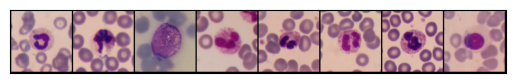

In [44]:
print(len(list(data.val_dataloader())))
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)
data.visualize(next(iter(data.train_dataloader())))

# Models

## Generic Model class

In [10]:
class Module(nn.Module, d2l.HyperParameters):   #@save
    """The base class of models"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError
    
    def forward(self, X):
        assert hasattr(self, "net"), "Neural network is defined"
        return self.net(X)
    
    def plot(self, key, value, train):
        """Plot a point in animation"""

        assert hasattr(self, "trainer"), "Trainer is not initiated"
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            '''
            Note: backward slash means newline. Forward slash is the usual division. 
            '''
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
            
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
            
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
        
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizer(self):
        return torch.optim.SGD(self.parameters(), lr = self.lr)
    
    def apply_init(self, inputs, init=None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

    def init_cnn(module):
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            nn.init.xavier_uniform_(module.weight)

## Generic Classifier

In [ ]:
class Classifier(d2l.Module):       
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions."""
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        print(Y_hat.shape[-1])
        print(Y_hat.shape)
        preds = Y_hat.argmax(axis=1).type(Y.dtype)
        compare = (preds == Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare

## Generic Testing

In [ ]:
test_module = d2l.Classifier()
test_module.layer_summary

## ResNet

In [23]:
class Residual(nn.Module):      #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)

        else:
            self.conv3 = None
        self.bn1=nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = nn.functional.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return nn.functional.relu(Y)

In [20]:
class ResNet(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super(ResNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))

        self.net.apply(d2l.init_cnn)

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True,strides=2))
            else:
                blk.append(Residual(num_channels))

        return nn.Sequential(*blk)

In [21]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, num_classes)

### Resnet Testing



In [24]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


/home/pachy/.cache/pypoetry/virtualenvs/bloodyai-tbuIkQdx-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Training

## ResNet v0.1

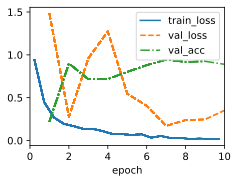

In [52]:
model = ResNet18(lr = 0.02, num_classes=5)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = CroppedCells(batch_size=128)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)